In [1]:
import numpy as np
import kwant
from scipy import linalg

# System creation

In [2]:
import kwant.continuum

hamiltonian_lead = ("(- mu + A*(k_x**2 + k_y**2))*sigma_0 + B*sigma_z - alpha*(k_x*sigma_y - k_y*sigma_x) ")

params = dict(
    mu = 0,
    A = 1,
    B = 0.5,
    alpha = 1.
)

a = 1

ham_lead_discretized_symbolic, ham_lead_coords = kwant.continuum.discretize_symbolic(hamiltonian_lead)
ham_lead_discretized = kwant.continuum.discretize(hamiltonian_lead, grid=a)

/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.W

In [3]:
lead = kwant.Builder(kwant.TranslationalSymmetry((-a, 0)))
    
def lead_shape(site):
    x, y = site.pos
    return (y==0)

lead.fill(ham_lead_discretized, lead_shape, (0, 0))

syst = kwant.Builder()
    
def syst_shape(site):
    x, y = site.pos
    return (x==0) and (y==0)

syst.fill(ham_lead_discretized, syst_shape, (0, 0))

syst.attach_lead(lead)

syst = syst.finalized()

### plot system

/var/folders/tq/z3lkw8s95r1g4v3_7b8tv3_w0000gn/T/ipykernel_70684/3601415165.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()


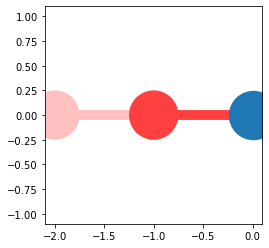

In [4]:
#kwant.plotter.set_engine("plotly")
#kwant.plotter.set_engine("matplotlib")
import matplotlib.pyplot as plt, matplotlib.backends
plot = kwant.plot(syst, show=False)
plot.show()

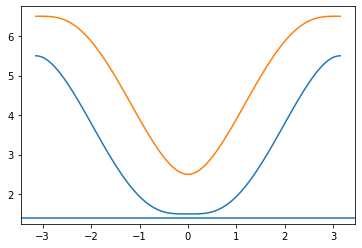

In [5]:
#fig = kwant.plotter.bands(syst.leads[0], params=params)
bands=kwant.physics.Bands(syst.leads[0], params=params)
momenta=np.linspace(-np.pi,np.pi,101)
energies=[bands(k) for k in momenta]
x=np.array(energies)
en=(x)
plt.plot(momenta, en)
plt.axhline(1.4)
#for i in range(len(syst.leads[0].modes(energy=energy, params=params)[0].momenta)):
#    plt.axvline(syst.leads[0].modes(energy=energy, params=params)[0].momenta[i])

In [68]:
#explicit diagonalisation
def explicit_diagonalisation(en):
    #following eq (5) of Istas et al.
    ham = syst.leads[0].cell_hamiltonian(params=params)
    hop = syst.leads[0].inter_cell_hopping(params=params)
    #print(hop)
    #print('check if h_hop is invertible')
    #print(np.linalg.inv(hop))
    #print(ham)
    #print(hop)
    A = np.block([[ham-en*np.identity(ham.shape[0]), hop.T.conj()], [np.identity(ham.shape[0]), np.zeros(ham.shape)]])
    B = np.block([[-hop, np.zeros(ham.shape)], [np.zeros(ham.shape), np.identity(ham.shape[0])]])
    #print(A)
    eigvals, eigvecs = linalg.eig(A, b=B)
    lambdas = 1./eigvals
    print('lambdas')
    print(lambdas)
    print('size of lambdas')
    print(np.abs(lambdas))
    print('phase of lambdas')
    print(np.angle(lambdas))
    print('eigenvectors')
    print(eigvecs)
    print(eigvecs[2:4]/eigvecs[0:2]) #checking if the lowest half of the eigenvectors are related to the top part by the corresponding eigenvalues.
    return lambdas, eigvecs
    
lambdas, eigvecs = explicit_diagonalisation(2.1)
lmbda = lambdas
phi = eigvecs[0:2]
phi_lmbda = eigvecs[2:4]
print('selection trial')
print(phi)
#phi_extended = eigvecs[:,0]

#print(lmbda)
#print(phi_extended)

def validation_basic(lmbda, phi_extended, en):
    #checking agreement between lhs and rhs of eq(5) given an eigenvector-eigenvalue pair from direct diagonalisation
    ham = syst.leads[0].cell_hamiltonian(params=params)
    hop = syst.leads[0].inter_cell_hopping(params=params)
    A = np.block([[ham-en*np.identity(ham.shape[0]), hop.T.conj()], [np.identity(ham.shape[0]), np.zeros(ham.shape)]])
    B = np.block([[-hop, np.zeros(ham.shape)], [np.zeros(ham.shape), np.identity(ham.shape[0])]])
    eigval = 1./lmbda
    lhs = A@phi_extended
    rhs = eigval*B@phi_extended
    print('lhs')
    print(lhs)
    print('rhs')
    print(rhs)
    
#validation_basic(lmbda, phi_extended, 3.1)

def validation(lmbda, phi, en):
    #checks if the eigenvector-eigenvalue pair gives 0 following eq (3)
    ham = syst.leads[0].cell_hamiltonian(params=params)
    hop = syst.leads[0].inter_cell_hopping(params=params)
    return hop@phi + lmbda*(ham-en*np.identity(ham.shape[0]))@phi + lmbda**2.*hop.T.conj()@phi

def hop_A_B_alternative(phi, phi_lmbda):
    hop = syst.leads[0].inter_cell_hopping(params=params)
    B = np.sqrt(np.linalg.norm(hop))*np.identity(hop.shape[0])
    A = hop@np.linalg.inv(B).T.conj()
    vecs = A.T.conj()@phi_lmbda
    vecslmbdainv = B.T.conj()@phi
    print('A B alternative')
    print(A.T.conj())
    print(B.T.conj())
    return vecslmbdainv[:,1], vecs[:,1]

def hop_A_B(phi, phi_lmbda):
    #breaks up hopping V into u s vh. Reconstructs vecs and vecslmbdainv following blog post and documentation. Exports some elements for comparison with the kwant version below.
    hop = syst.leads[0].inter_cell_hopping(params=params)
    u, s, v_dagger = linalg.svd(hop)
    print('hop')
    print(hop)
    print()
    s = np.diag(s)
    print('phi phi_lmbda')
    print(phi)
    print(phi_lmbda)
    print('u s vh')
    print(u)
    print(s)
    print(v_dagger)
    A_dagger = np.sqrt(s)@v_dagger
    B_dagger = np.sqrt(s)@u.T.conj()
    A_alternative = np.sqrt(np.linalg.norm(hop))
    B_dagger_alternative = hop.T.conj()
    print('A B')
    print(A_dagger)
    print(A_alternative)
    print(B_dagger)
    print('hop')
    print(hop)
    print(B_dagger.T.conj()@A_dagger)
    vecs = B_dagger@phi_lmbda
    veclmbdainv = A_dagger@phi
    print('vecs')
    print(vecs)
    print('veclmbdainv')
    print(veclmbdainv)
    print('vecs/veclmbdainv')
    print(vecs/veclmbdainv)
    compare = veclmbdainv[:,1]
    compare3 = vecs[:,1]
    print('sqrt_hop')
    sqrt_hop = v_dagger.T.conj()@np.sqrt(s)
    print(sqrt_hop)
    return compare, compare3
    
compare, compare3 = hop_A_B(phi, phi_lmbda)
compare5, compare6 = hop_A_B_alternative(phi, phi_lmbda)
print('compare')
#print(compare)
#print(compare3)
print(np.around(compare5, 2))
print(np.around(compare6, 2))
print(np.abs(compare5))
print(np.abs(compare6))
#print(compare6/compare5)
#print((0.21423648+8.24682518e-01j)/(0.75894664-0.33571809j))
#print(vecs_direct[0]/vecslmbdainv_direct[0])
#print(vecs_direct[1]/vecslmbdainv_direct[1])

#print(validation(lmbda, phi, 2.1))

lambdas
[0.43503846-9.00411870e-01j 0.66407968+1.13443044e-17j
 0.43503846+9.00411870e-01j 1.50584339-4.76414147e-19j]
size of lambdas
[1.         0.66407968 1.         1.50584339]
phase of lambdas
[-1.12071533e+00  1.70827459e-17  1.12071533e+00 -3.16376955e-19]
eigenvectors
[[-0.07803467-0.35006043j  0.34948196+0.64199645j  0.23822314-0.26810716j
  -0.48539524+0.00417725j]
 [ 0.59480061-0.13259158j -0.19104586-0.3509502j  -0.45555077-0.40477374j
  -0.26534346+0.00228351j]
 [-0.34914665-0.08202641j  0.23208387+0.4263368j   0.3450431 +0.09786202j
  -0.73092921+0.00629028j]
 [ 0.13937411-0.59324796j -0.12686968-0.2330589j   0.16628097-0.58627547j
  -0.39956569+0.00343861j]]
[[0.43503846-9.00411870e-01j 0.66407968-1.00050973e-16j
  0.43503846+9.00411870e-01j 1.50584339-5.52116928e-16j]
 [0.43503846-9.00411870e-01j 0.66407968+7.93104740e-16j
  0.43503846+9.00411870e-01j 1.50584339+3.48104249e-16j]]
selection trial
[[-0.07803467-0.35006043j  0.34948196+0.64199645j  0.23822314-0.26810716j
 

ModuleNotFoundError: No module named 'pandas'

In [69]:
energy = 2.1
print('translation eigenvectors: ')
print(syst.leads[0].modes(energy=energy, params=params)[1].vecs)
print('translation eigenvectors divided by corresponding eigenvalue: ')
print(syst.leads[0].modes(energy=energy, params=params)[1].vecslmbdainv)
print('eigenvalues: ') # only valid for single eigenvector
eigenvalue = syst.leads[0].modes(energy=energy, params=params)[1].vecs/syst.leads[0].modes(energy=energy, params=params)[1].vecslmbdainv
print(-eigenvalue)
print(-eigenvalue[0,:]/eigenvalue[1,:])
print('eigenvalue size')
print(np.abs(eigenvalue))
print('eigenvalue phase')
print(np.angle(-eigenvalue))
print('sqrt_hop')
print(syst.leads[0].modes(energy=energy, params=params)[1].sqrt_hop)
print('momenta', syst.leads[0].modes(energy=energy, params=params)[0].momenta)
#print(np.angle(eigenvalue)/syst.leads[0].modes(energy=energy, params=params)[0].momenta)
print('wavefunctions', syst.leads[0].modes(energy=energy, params=params)[0].wave_functions)
print('wavefunc size')
print(np.abs(syst.leads[0].modes(energy=energy, params=params)[0].wave_functions))
print('wavefunc/eigenvectors')
#print(np.abs(syst.leads[0].modes(energy=energy, params=params)[0].wave_functions)/syst.leads[0].modes(energy=energy, params=params)[1].vecs[:,:2])
print('number of left/right-moving modes: ', syst.leads[0].modes(energy=energy, params=params)[1].nmodes)
print('part of the SVD of h_hop: ', syst.leads[0].modes(energy=energy, params=params)[1].sqrt_hop)
#print(2.82403222+0.31756043)
#print(1/np.sqrt(2))
compare2 = syst.leads[0].modes(energy=energy, params=params)[1].vecslmbdainv[:,-1]
compare4 = syst.leads[0].modes(energy=energy, params=params)[1].vecs[:,-1]
print('compare')
print(compare2)
print(compare4)
print('quot')
quot1 = compare5/compare2
quot2 = compare6/compare4
#expect the two versions of vecs to be related by a normalisation constant, so quot1 and quot2 should have been a 1D array of a constant value.
#Instead, they are giving a pair of complex conjugates. This goes into how in the reconstructed version sqrt_hop is 1.05737126*sigma_z,
#but in the kwant version it is 1.25743343*sigma_0. (so sort of going into different basis, one where both two orbitals propagate in the same direction,
#the other where they propogate in opposite directions) Also 1.05737126/1.25743343 = 0.8408964117201047 = 1/np.sqrt(np.sqrt(2)).
print(quot1)
print(quot2)
print(np.abs(quot1))
print(np.angle(quot1))
print(np.abs(quot2))
print(np.angle(quot2))
#abs values of quot1 and quot2 does not look like anything. Not sure how kwant normalises vecs and veclmbdainv. We need to know
#this when calculating eigenvectors from kwant, as the relative weights in the boundstate algorithm in the basis of evanescent modes
#are based on the kwant-normalised vecslmbdainv.
print(np.abs(quot1/quot2))
print(1./np.sqrt(np.sqrt(2.)))
#print(1./1.25743343)
#quot1/quot2 gives 1/sqrt(# orbitals), as we observed last week.

translation eigenvectors: 
[[ 0.10405439-0.4317285j   0.10405439+0.4317285j   0.24240619+0.j        ]
 [ 0.58958983-0.10823002j  0.58958983+0.10823002j -0.34914684+0.j        ]]
translation eigenvectors divided by corresponding eigenvalue: 
[[-0.32511781+0.42503721j -0.32511781-0.42503721j -0.79424523+0.j        ]
 [-0.72219643-0.55241969j -0.72219643+0.55241969j  0.43417767+0.j        ]]
eigenvalues: 
[[0.75894664-0.33571809j 0.75894664+0.33571809j 0.3052032 +0.j        ]
 [0.44271887-0.4885051j  0.44271887+0.4885051j  0.80415661-0.j        ]]
[-1.15038464-0.51104819j -1.15038464+0.51104819j -0.37953205-0.j        ]
eigenvalue size
[[0.82988351 0.82988351 0.3052032 ]
 [0.65927023 0.65927023 0.80415661]]
eigenvalue phase
[[-0.41647185  0.41647185  0.        ]
 [-0.8345264   0.8345264  -0.        ]]
sqrt_hop
[[1.25743343 0.        ]
 [0.         1.25743343]]
momenta [-1.12071533  1.12071533]
wavefunctions [[-0.25855668+0.33801966j -0.25855668-0.33801966j]
 [-0.57434168-0.43932321j -0.57

In [85]:
def qz_decomp(en):
    ham = syst.leads[0].cell_hamiltonian(params=params)
    hop = syst.leads[0].inter_cell_hopping(params=params)
    A = np.block([[ham-en*np.identity(ham.shape[0]), hop.T.conj()], [np.identity(ham.shape[0]), np.zeros(ham.shape)]])
    B = np.block([[-hop, np.zeros(ham.shape)], [np.zeros(ham.shape), np.identity(ham.shape[0])]])
    if (np.all(np.imag(A)==0.)) and (np.all(np.imag(B)==0.)):
        A = np.real(A)
        B = np.real(B)
    AA, BB, Q, Z = linalg.qz(A, B, output='complex')
    print(AA)
    print(BB)
    print(Q)
    print(Z)
    print('BB/AA')
    print(BB/AA)
    return AA, BB, Q, Z, A
    
AA, BB, Q, Z, A_play = qz_decomp(1.4)
print('Z')
phi_Z = Z.T.conj()[0:2]
print(Z)
print('checking orthogonality of Z')
print(np.dot(Z.T.conj()[:,2], Z.T.conj()[:,3]))
#phi_Q = Q[0:2]
#phi_Z = Z[0:2]
phi_lmbda_Z = Z.T.conj()[2:4]
#phi_lmbda_Q = Q[2:4]
#phi_lmbda_Z = Z[2:4]
print(phi_Z[0]/phi_Z[1])
print(phi_Q[0]/phi_Q[1])

def hop_A_B_alternative(phi, phi_lmbda):
    hop = syst.leads[0].inter_cell_hopping(params=params)
    B = np.sqrt(np.linalg.norm(hop))*np.identity(hop.shape[0])
    A = hop@np.linalg.inv(B).T.conj()
    vecs = A.T.conj()@phi_lmbda
    vecslmbdainv = B.T.conj()@phi
    print('A B alternative')
    print(A.T.conj())
    print(B.T.conj())
    return vecslmbdainv[:,0], vecs[:,0]

compare7, compare8 = hop_A_B_alternative(phi_Z, phi_lmbda_Z)
print('compare')
print(compare7)
print(compare8)

[[ 1.59099139+0.53227525j -0.43823916+1.03770557j -1.75585782-0.44379083j
  -0.75937678-0.75176785j]
 [ 0.        +0.j          1.583781  -0.52986297j -1.14786412+1.32765831j
   1.71189643-0.34704087j]
 [ 0.        +0.j          0.        +0.j          0.63486794+0.21239869j
  -0.4298217 +0.13153324j]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.63199071-0.2114361j ]]
[[ 1.08457942+0.j         -0.01664681+0.02750492j -0.06025609+0.03873459j
  -0.03880238-0.05808854j]
 [ 0.        +0.j          1.07966409+0.j         -0.05875564+0.04866157j
   0.06956369+0.01958111j]
 [ 0.        +0.j          0.        +0.j          1.03553874+0.j
  -0.03034115+0.00465724j]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   1.03084566+0.j        ]]
[[-0.32210991-0.53215102j  0.65625036-0.16659429j  0.02916598+0.31696657j
   0.15482134+0.17133068j]
 [ 0.57641198+0.17389254j  0.23227207-0.4410221j  -0.23019146+0.37259151j
   0.09781205-0.43322057j]
 [-0.0896811

/var/folders/tq/z3lkw8s95r1g4v3_7b8tv3_w0000gn/T/ipykernel_14624/2982664221.py:15: RuntimeWarning: invalid value encountered in true_divide
  print(BB/AA)


In [70]:
#explicit diagonalisation
def explicit_diagonalisation(en):
    #following eq (5) of Istas et al.
    ham = syst.leads[0].cell_hamiltonian(params=params)
    hop = syst.leads[0].inter_cell_hopping(params=params)
    #print(ham)
    #print(hop)
    A = np.block([[ham-en*np.identity(ham.shape[0]), hop.T.conj()], [np.identity(ham.shape[0]), np.zeros(ham.shape)]])
    B = np.block([[-hop, np.zeros(ham.shape)], [np.zeros(ham.shape), np.identity(ham.shape[0])]])
    print(A)
    eigvals, eigvecs = linalg.eig(A, b=B)
    lambdas = 1./eigvals
    print('lambdas')
    print(lambdas)
    print('size of lambdas')
    print(np.abs(lambdas))
    print('phase of lambdas')
    print(np.angle(lambdas))
    print('eigenvectors')
    print(eigvecs)
    print(eigvecs[2:4]/eigvecs[0:2]) #checking if the lowest half of the eigenvectors are related to the top part by the corresponding eigenvalues.
    return lambdas, eigvecs
    
lambdas, eigvecs = explicit_diagonalisation(1.4)
lmbda = lambdas
phi = eigvecs[0:2]
phi_lmbda = eigvecs[2:4]
print('selection trial')
print(phi)
#phi_extended = eigvecs[:,0]

#print(lmbda)
#print(phi_extended)

def validation_basic(lmbda, phi_extended, en):
    #checking agreement between lhs and rhs of eq(5) given an eigenvector-eigenvalue pair from direct diagonalisation
    ham = syst.leads[0].cell_hamiltonian(params=params)
    hop = syst.leads[0].inter_cell_hopping(params=params)
    A = np.block([[ham-en*np.identity(ham.shape[0]), hop.T.conj()], [np.identity(ham.shape[0]), np.zeros(ham.shape)]])
    B = np.block([[-hop, np.zeros(ham.shape)], [np.zeros(ham.shape), np.identity(ham.shape[0])]])
    eigval = 1./lmbda
    lhs = A@phi_extended
    rhs = eigval*B@phi_extended
    print('lhs')
    print(lhs)
    print('rhs')
    print(rhs)
    
#validation_basic(lmbda, phi_extended, 3.1)

def validation(lmbda, phi, en):
    #checks if the eigenvector-eigenvalue pair gives 0 following eq (3)
    ham = syst.leads[0].cell_hamiltonian(params=params)
    hop = syst.leads[0].inter_cell_hopping(params=params)
    return hop@phi + lmbda*(ham-en*np.identity(ham.shape[0]))@phi + lmbda**2.*hop.T.conj()@phi

def hop_A_B_alternative(phi, phi_lmbda):
    hop = syst.leads[0].inter_cell_hopping(params=params)
    B = np.sqrt(np.linalg.norm(hop))*np.identity(hop.shape[0])
    A = hop@np.linalg.inv(B).T.conj()
    vecs = A.T.conj()@phi_lmbda
    vecslmbdainv = B.T.conj()@phi
    print('A B alternative')
    print(A.T.conj())
    print(B.T.conj())
    return vecslmbdainv[:,0:2], vecs[:,0:2]


def schur_decomp(eigvecs):
    #eigvecs = np.pad(eigvecs, ((0, 0), (0, 2)), mode='constant', constant_values=0.)
    print(eigvecs)
    T, Z = linalg.schur(eigvecs, output='real')
    #T_vecslmbdainv, Z_vecslmbdainv = linalg.schur(vecslmbdainv, output='real')
    print('Schur decomposition')
    print(T)
    print(Z)
    return T, Z

def hop_A_B(phi, phi_lmbda):
    #breaks up hopping V into u s vh. Reconstructs vecs and vecslmbdainv following blog post and documentation. Exports some elements for comparison with the kwant version below.
    hop = syst.leads[0].inter_cell_hopping(params=params)
    u, s, v_dagger = linalg.svd(hop)
    print('hop')
    print(hop)
    print()
    s = np.diag(s)
    print('phi phi_lmbda')
    print(phi)
    print(phi_lmbda)
    print('u s vh')
    print(u)
    print(s)
    print(v_dagger)
    A_dagger = np.sqrt(s)@v_dagger
    B_dagger = np.sqrt(s)@u.T.conj()
    A_alternative = np.sqrt(np.linalg.norm(hop))
    B_dagger_alternative = hop.T.conj()
    print('A B')
    print(A_dagger)
    print(A_alternative)
    print(B_dagger)
    print('hop')
    print(hop)
    print(B_dagger.T.conj()@A_dagger)
    vecs = B_dagger@phi_lmbda
    veclmbdainv = A_dagger@phi
    print('vecs')
    print(vecs)
    print('veclmbdainv')
    print(veclmbdainv)
    print('vecs/veclmbdainv')
    print(vecs/veclmbdainv)
    compare = veclmbdainv[:,0]
    compare3 = vecs[:,0]
    print('sqrt_hop')
    sqrt_hop = v_dagger.T.conj()@np.sqrt(s)
    print(sqrt_hop)
    return compare, compare3
    
compare, compare3 = hop_A_B(phi, phi_lmbda)
compare5, compare6 = hop_A_B_alternative(phi, phi_lmbda)
T, Z = schur_decomp(eigvecs)
print('compare')
print(compare)
print(compare3)
print(compare5)
print(compare6)
print('trial')
print(eigvecs.T.conj()@eigvecs)
print(eigvecs@eigvecs.T.conj())
print(eigvecs@eigvecs.T.conj()-eigvecs.T.conj()@eigvecs)
#print((0.21423648+8.24682518e-01j)/(0.75894664-0.33571809j))
#print(vecs_direct[0]/vecslmbdainv_direct[0])
#print(vecs_direct[1]/vecslmbdainv_direct[1])

#print(validation(lmbda, phi, 2.1))

[[ 3.1+0.j  0. +0.j -1. -0.j -0.5-0.j]
 [ 0. +0.j  2.1+0.j  0.5-0.j -1. -0.j]
 [ 1. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  1. +0.j  0. +0.j  0. +0.j]]
lambdas
[0.61307986-0.20510937j 0.61307986+0.20510937j 1.46692014-0.4907665j
 1.46692014+0.4907665j ]
size of lambdas
[0.64648029 0.64648029 1.54683757 1.54683757]
phase of lambdas
[-0.32285029  0.32285029 -0.32285029  0.32285029]
eigenvectors
[[-0.0294172 -0.38628792j  0.3863028 +0.02922119j  0.02532778-0.24916664j
  -0.24917946+0.02520135j]
 [ 0.63987317+0.38174423j -0.38206885-0.6396794j   0.41977499-0.23624855j
  -0.23646151+0.41965507j]
 [-0.09726636-0.2307916j   0.23084093+0.09714925j -0.08512881-0.37793758j
  -0.37789434-0.08532056j]
 [ 0.47059267+0.10279572j -0.10303448-0.47054045j  0.49983351-0.55256927j
  -0.55282281+0.49955308j]]
[[0.61307986-0.20510937j 0.61307986+0.20510937j 1.46692014-0.4907665j
  1.46692014+0.4907665j ]
 [0.61307986-0.20510937j 0.61307986+0.20510937j 1.46692014-0.4907665j
  1.46692014+0.4907665j ]]
s

In [55]:
def inverse_A_B_alt(vecslmbdainv, vecs):
    hop = syst.leads[0].inter_cell_hopping(params=params)
    B = np.sqrt(np.linalg.norm(hop))*np.identity(hop.shape[0])
    A = hop@np.linalg.inv(B).T.conj()
    B_dagger_inv = np.linalg.inv(B.T.conj())
    A_dagger_inv = np.linalg.inv(A.T.conj())
    phi_lmbda = A_dagger_inv@vecs
    phi = B_dagger_inv@vecslmbdainv
    return phi, phi_lmbda

energy = 1.4
vecs = syst.leads[0].modes(energy=energy, params=params)[1].vecs[:,0]
vecslmbdainv = syst.leads[0].modes(energy=energy, params=params)[1].vecslmbdainv[:,0]
phi_recreated, phi_lmbda_recreated = inverse_A_B_alt(vecslmbdainv, vecs)
print(vecslmbdainv, vecs)
print(phi_recreated, phi_lmbda_recreated)
print(phi_recreated[0]/phi_recreated[1])
print(phi_lmbda_recreated[0]/phi_lmbda_recreated[1])

[-0.29021426+0.j  0.86677686+0.j] [-0.00585603+0.j -0.40551111+0.j]
[-0.23079891+0.j  0.68932227+0.j] [-0.19807043+0.j  0.410868  +0.j]
(-0.3348200380185509+0j)
(-0.48207801448458343+0j)


In [22]:
A = np.array([[0, 2, 2], [0, 1, 2], [1, 0, 1]])
#print(A_play@A_play.T.conj())
#print(A_play.T.conj()@A_play)
#print(A.T.conj()@A)
#print(A@A.T.conj())
T, Z = linalg.schur(np.real(A_play))
print(T)
print(Z)

[[ 2.69290028 -0.63742776 -1.69610731  0.98331371]
 [ 0.          1.57996919 -0.98331371 -1.69610731]
 [ 0.          0.          0.46356527  0.46930774]
 [ 0.          0.         -0.16812002  0.46356527]]
[[-0.92053947  0.20005899  0.18503141 -0.27990508]
 [-0.17725717 -0.81562053  0.45945235  0.30372123]
 [-0.34183942 -0.01129069 -0.61918486  0.706844  ]
 [-0.06582389 -0.54278179 -0.60932506 -0.57426311]]


In [86]:
energy = 1.4
print('translation eigenvectors: ')
print(syst.leads[0].modes(energy=energy, params=params)[1].vecs)
print('translation eigenvectors divided by corresponding eigenvalue: ')
print(syst.leads[0].modes(energy=energy, params=params)[1].vecslmbdainv)
print('eigenvalues: ') # only valid for single eigenvector
eigenvalue = syst.leads[0].modes(energy=energy, params=params)[1].vecs/syst.leads[0].modes(energy=energy, params=params)[1].vecslmbdainv
print(-eigenvalue)
print(-eigenvalue[0,:]/eigenvalue[1,:])
print('eigenvalue size')
print(np.abs(eigenvalue))
print('eigenvalue phase')
print(np.angle(-eigenvalue))
print('sqrt_hop')
print(syst.leads[0].modes(energy=energy, params=params)[1].sqrt_hop)
print('momenta', syst.leads[0].modes(energy=energy, params=params)[0].momenta)
#print(np.angle(eigenvalue)/syst.leads[0].modes(energy=energy, params=params)[0].momenta)
print('wavefunctions', syst.leads[0].modes(energy=energy, params=params)[0].wave_functions)
print('wavefunc size')
print(np.abs(syst.leads[0].modes(energy=energy, params=params)[0].wave_functions))
print('wavefunc/eigenvectors')
#print(np.abs(syst.leads[0].modes(energy=energy, params=params)[0].wave_functions)/syst.leads[0].modes(energy=energy, params=params)[1].vecs[:,:2])
print('number of left/right-moving modes: ', syst.leads[0].modes(energy=energy, params=params)[1].nmodes)
print('part of the SVD of h_hop: ', syst.leads[0].modes(energy=energy, params=params)[1].sqrt_hop)
#print(2.82403222+0.31756043)
#print(1/np.sqrt(2))
compare2 = syst.leads[0].modes(energy=energy, params=params)[1].vecslmbdainv[:,0]
compare4 = syst.leads[0].modes(energy=energy, params=params)[1].vecs[:,0]
print('compare')
print(compare2)
print(compare4)
print('quot')
quot1 = compare7/compare2
quot2 = compare8/compare4
#expect the two versions of vecs to be related by a normalisation constant, so quot1 and quot2 should have been a 1D array of a constant value.
#Instead, they are giving a pair of complex conjugates. This goes into how in the reconstructed version sqrt_hop is 1.05737126*sigma_z,
#but in the kwant version it is 1.25743343*sigma_0. (so sort of going into different basis, one where both two orbitals propagate in the same direction,
#the other where they propogate in opposite directions) Also 1.05737126/1.25743343 = 0.8408964117201047 = 1/np.sqrt(np.sqrt(2)).
print(quot1)
print(quot2)
print(np.abs(quot1))
print(np.angle(quot1))
print(np.abs(quot2))
print(np.angle(quot2))
#abs values of quot1 and quot2 does not look like anything. Not sure how kwant normalises vecs and veclmbdainv. We need to know
#this when calculating eigenvectors from kwant, as the relative weights in the boundstate algorithm in the basis of evanescent modes
#are based on the kwant-normalised vecslmbdainv.
print(np.abs(quot1/quot2))
#print(1./1.25743343)
#quot1/quot2 gives 1/sqrt(# orbitals), as we observed last week.

translation eigenvectors: 
[[-0.00585603+0.j  0.41517552+0.j]
 [-0.40551111+0.j  0.22855266+0.j]]
translation eigenvectors divided by corresponding eigenvalue: 
[[-0.29021426+0.j -0.86218946+0.j]
 [ 0.86677686+0.j -0.17894773+0.j]]
eigenvalues: 
[[-0.02017831+0.j  0.4815363 +0.j]
 [ 0.46783794-0.j  1.27720346+0.j]]
[ 0.04313097-0.j -0.37702396-0.j]
eigenvalue size
[[0.02017831 0.4815363 ]
 [0.46783794 1.27720346]]
eigenvalue phase
[[ 3.14159265  0.        ]
 [-0.          0.        ]]
sqrt_hop
[[1.25743343 0.        ]
 [0.         1.25743343]]
momenta []
wavefunctions []
wavefunc size
[]
wavefunc/eigenvectors
number of left/right-moving modes:  0
part of the SVD of h_hop:  [[1.25743343 0.        ]
 [0.         1.25743343]]
compare
[-0.29021426+0.j  0.86677686+0.j]
[-0.00585603+0.j -0.40551111+0.j]
quot
[0.12745813-1.6736991j  0.98267833+0.47752993j]
[2.96364982-62.96270381j 0.46308317 +0.56230485j]
[1.67854528 1.09256191]
[-1.49478948  0.45234242]
[63.03241461  0.72844545]
[-1.52376112

In [10]:
#validation
#V^dagger Phi_e lambda_e = sqrt_hop@vecs?
hop = syst.leads[0].inter_cell_hopping(params=params)
phi_elambda_e = eigvecs[2:4][:,0:2]
lhs = hop.T.conj()@phi_elambda_e
sqrt_hop = syst.leads[0].modes(energy=1.1, params=params)[1].sqrt_hop
evan_vecs = slice(2 * syst.leads[0].modes(energy=1.1, params=params)[1].nmodes, None)
vecs = syst.leads[0].modes(energy=1.1, params=params)[1].vecs[:, evan_vecs]
print(phi_elambda_e)
print(hop)
print(vecs)
print(sqrt_hop)
print('lhs vs rhs')
#print(vecs)
rhs = sqrt_hop@vecs
print(lhs)
print(rhs)
print(lhs/rhs)
print(np.abs(lhs/rhs))
#print(phi_elambda_e/vecs.flatten())

[[ 0.08510317-0.23843679j  0.23825906-0.08559949j]
 [ 0.25094321+0.26432317j -0.26484515-0.25039226j]]
[[-1. +0.j  0.5+0.j]
 [-0.5+0.j -1. +0.j]]
[[ 0.05528136+0.j -0.30915562+0.j]
 [-0.31276453+0.j -0.20246711+0.j]]
[[1.25743343 0.        ]
 [0.         1.25743343]]
lhs vs rhs
[[-0.21057478+0.1062752j  -0.10583649+0.21079562j]
 [-0.20839163-0.38354157j  0.38397468+0.20759252j]]
[[ 0.06951263+0.j -0.38874261+0.j]
 [-0.39328057+0.j -0.25458891+0.j]]
[[-3.02930231+1.52886174j  0.27225338-0.54224984j]
 [ 0.52988029+0.9752365j  -1.50821445-0.81540282j]]
[[3.39324191 0.60675925]
 [1.1098916  1.71452401]]


In [11]:
#lambda_e^star Phi_e^dagger V Phi_e = vecs^dagger@vecslmbdainv?
phi_elambda_e = eigvecs[2:4][:,0:2]
hop = syst.leads[0].inter_cell_hopping(params=params)
phi_e = eigvecs[0:2][:,0:2]
print(phi_e)
print(phi_elambda_e)
lhs = phi_elambda_e.T.conj()@hop@phi_e
print('lhs')
print(lhs)
evan_vecs = slice(2 * syst.leads[0].modes(energy=1.1, params=params)[1].nmodes, None)
vecs = syst.leads[0].modes(energy=1.1, params=params)[1].vecs[:, evan_vecs]
vecslmbdainv = syst.leads[0].modes(energy=1.1, params=params)[1].vecslmbdainv[:, evan_vecs]
print(vecs)
print(vecslmbdainv)
rhs = vecs.T.conj()@vecslmbdainv
print('rhs')
print(rhs)
print(lhs/rhs)
print(np.abs(lhs/rhs))

[[ 0.34427061-0.37794958j  0.37723188-0.34505688j]
 [ 0.2616595 +0.6879188j  -0.68846217-0.26022647j]]
[[ 0.08510317-0.23843679j  0.23825906-0.08559949j]
 [ 0.25094321+0.26432317j -0.26484515-0.25039226j]]
lhs
[[-0.43103448+4.16333634e-17j  0.12717091-1.77254963e-01j]
 [ 0.12717091+1.77254963e-01j -0.43103448+5.55111512e-17j]]
[[ 0.05528136+0.j -0.30915562+0.j]
 [-0.31276453+0.j -0.20246711+0.j]]
[[-0.38567261+0.j  0.86753871+0.j]
 [ 0.86624417+0.j  0.33287604+0.j]]
rhs
[[-0.29225096+0.j -0.0561531 +0.j]
 [-0.0561531 +0.j -0.33560092+0.j]]
[[ 1.47487792-1.42457578e-16j -2.26471762+3.15663731e+00j]
 [-2.26471762-3.15663731e+00j  1.28436621-1.65408221e-16j]]
[[1.47487792 3.8850103 ]
 [3.8850103  1.28436621]]


In [12]:
energy = 2.1
print('translation eigenvectors: ')
print(syst.leads[0].modes(energy=energy, params=params, stabilization=[True, True])[1].vecs)
print('translation eigenvectors divided by corresponding eigenvalue: ')
print(syst.leads[0].modes(energy=energy, params=params)[1].vecslmbdainv)
print('eigenvalues: ') # only valid for single eigenvector
eigenvalue = syst.leads[0].modes(energy=energy, params=params)[1].vecs/syst.leads[0].modes(energy=energy, params=params)[1].vecslmbdainv
print(-eigenvalue)
print(-eigenvalue[0,:]/eigenvalue[1,:])
print('eigenvalue size')
print(np.abs(eigenvalue))
print('eigenvalue phase')
print(np.angle(-eigenvalue))
print('sqrt_hop')
print(syst.leads[0].modes(energy=energy, params=params)[1].sqrt_hop)
print('momenta', syst.leads[0].modes(energy=energy, params=params)[0].momenta)
#print(np.angle(eigenvalue)/syst.leads[0].modes(energy=energy, params=params)[0].momenta)
print('wavefunctions', syst.leads[0].modes(energy=energy, params=params)[0].wave_functions)
print('wavefunc size')
print(np.abs(syst.leads[0].modes(energy=energy, params=params)[0].wave_functions))
print('wavefunc/eigenvectors')
#print(np.abs(syst.leads[0].modes(energy=energy, params=params)[0].wave_functions)/syst.leads[0].modes(energy=energy, params=params)[1].vecs[:,:2])
print('number of left/right-moving modes: ', syst.leads[0].modes(energy=energy, params=params)[1].nmodes)
print('part of the SVD of h_hop: ', syst.leads[0].modes(energy=energy, params=params)[1].sqrt_hop)
#print(2.82403222+0.31756043)
#print(1/np.sqrt(2))
compare2 = syst.leads[0].modes(energy=energy, params=params)[1].vecslmbdainv[:,0]
compare4 = syst.leads[0].modes(energy=energy, params=params)[1].vecs[:,0]
print('compare')
print(compare2)
print(compare4)
print('quot')
quot1 = compare5/compare2
quot2 = compare6/compare4
#expect the two versions of vecs to be related by a normalisation constant, so quot1 and quot2 should have been a 1D array of a constant value.
#Instead, they are giving a pair of complex conjugates. This goes into how in the reconstructed version sqrt_hop is 1.05737126*sigma_z,
#but in the kwant version it is 1.25743343*sigma_0. (so sort of going into different basis, one where both two orbitals propagate in the same direction,
#the other where they propogate in opposite directions) Also 1.05737126/1.25743343 = 0.8408964117201047 = 1/np.sqrt(np.sqrt(2)).
print(quot1)
print(quot2)
print(np.abs(quot1))
print(np.angle(quot1))
print(np.abs(quot2))
print(np.angle(quot2))
#abs values of quot1 and quot2 does not look like anything. Not sure how kwant normalises vecs and veclmbdainv. We need to know
#this when calculating eigenvectors from kwant, as the relative weights in the boundstate algorithm in the basis of evanescent modes
#are based on the kwant-normalised vecslmbdainv.
print(np.abs(quot1/quot2))
print(1./np.sqrt(np.sqrt(2.)))
#print(1./1.25743343)
#quot1/quot2 gives 1/sqrt(# orbitals), as we observed last week.

translation eigenvectors: 


TypeError: got an unexpected keyword argument 'stabilization'

In [98]:
print(1.12075607/1.25609416)
print(1.15723562/1.33919427)

0.8922548210876167
0.8641282642286097


In [42]:
print(1./1.18920712)
print(-1.41421356/1.68179283)
print(0.24819476/-0.3510004)
print(1./np.sqrt(np.sqrt(2.)))
print((-0.24088626)/0.46837512)
print(0.97055335/(-1.33440052))
print(1.05737126/1.25743343)
print(0.3052032**2.+0.80415661**2.)
print(2.26928179/1.12071533)

0.8408964117201047
-0.8408964140963784
-0.7071067725278946
0.8408964152537146
-0.5143019979370381
-0.7273328625501435
0.8408964123055007
0.7398168466969322
2.024851208201105


In [9]:
energy = -2.1
print('translation eigenvectors: ', syst.leads[0].modes(energy=energy, params=params)[1].vecs)
print('translation eigenvectors divided by corresponding eigenvalue: ', syst.leads[0].modes(energy=energy, params=params)[1].vecslmbdainv)
print('eigenvalues: ', syst.leads[0].modes(energy=energy, params=params)[1].vecs/syst.leads[0].modes(energy=energy, params=params)[1].vecslmbdainv) # only valid for single eigenvector
print('number of left/right-moving modes: ', syst.leads[0].modes(energy=energy, params=params)[1].nmodes)
print('part of the SVD of h_hop: ', syst.leads[0].modes(energy=energy, params=params)[1].sqrt_hop)

translation eigenvectors:  [[-0.13722699  0.        ]
 [ 0.          0.15252566]]
translation eigenvectors divided by corresponding eigenvalue:  [[ 0.99053963  0.        ]
 [ 0.         -0.98829951]]
eigenvalues:  [[-0.13853761         nan]
 [        nan -0.15433141]]
number of left/right-moving modes:  0
part of the SVD of h_hop:  [[1.68179283 0.        ]
 [0.         1.68179283]]


/var/folders/tq/z3lkw8s95r1g4v3_7b8tv3_w0000gn/T/ipykernel_954/3066914267.py:4: RuntimeWarning: invalid value encountered in true_divide
  print('eigenvalues: ', syst.leads[0].modes(energy=energy, params=params)[1].vecs/syst.leads[0].modes(energy=energy, params=params)[1].vecslmbdainv) # only valid for single eigenvector


In [19]:
eigenvalue2 = syst.leads[0].modes(energy=energy, params=params)[1].vecs[0,0]/syst.leads[0].modes(energy=energy, params=params)[1].vecslmbdainv[0,0]
print(-1*np.log(-eigenvalue2))

0.4949329230945269


In [10]:
print(0.14375573/(-0.10165065))
print(0.20425918/(-0.14443305))

-1.4142135834842178
-1.4142135750785572


In [142]:
print(0.14443305/0.20425918)

0.7071067748338166
